In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from IPython.display import clear_output
from skimage import measure, morphology, segmentation

In [2]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5
DATA_DIR = "D:\Kunal\CLLG\SEM2\Grain_sort\Rice Dataset prepared"  # Update this path to your dataset folder
CLASSES = ["9_Bashful", "2_Bashmoti"]

<>:4: SyntaxWarning: invalid escape sequence '\K'
<>:4: SyntaxWarning: invalid escape sequence '\K'
C:\Users\Admin\AppData\Local\Temp\ipykernel_1476\3932077180.py:4: SyntaxWarning: invalid escape sequence '\K'
  DATA_DIR = "D:\Kunal\CLLG\SEM2\Grain_sort\Rice Dataset prepared"  # Update this path to your dataset folder


In [3]:
# 1. Data Loading and Preprocessing
def load_data(data_dir):
    images = []
    labels = []
    
    for idx, class_name in enumerate(CLASSES):
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.exists(class_dir):
            print(f"Warning: {class_dir} does not exist")
            continue
            
        for img_file in os.listdir(class_dir):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(class_dir, img_file)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, IMG_SIZE)
                images.append(img)
                labels.append(idx)
    
    return np.array(images), np.array(labels)


In [4]:
# Data augmentation
def create_data_generators(X_train, y_train, X_val, y_val):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    val_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow(
        X_train, y_train,
        batch_size=BATCH_SIZE
    )
    
    val_generator = val_datagen.flow(
        X_val, y_val,
        batch_size=BATCH_SIZE
    )
    
    return train_generator, val_generator

In [5]:
# 2. CNN Model
def create_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


In [6]:
# 3. Model Training and Evaluation
def train_model():
    print("Loading dataset...")
    images, labels = load_data(DATA_DIR)
    
    if len(images) == 0:
        print("No images found! Check your dataset path.")
        return None
    
    print(f"Loaded {len(images)} images with {len(np.unique(labels))} classes")
    
    # Split the data
    X_train, X_val, y_train, y_val = train_test_split(
        images, labels, test_size=0.2, random_state=42, stratify=labels
    )
    
    # Create data generators
    train_generator, val_generator = create_data_generators(X_train, y_train, X_val, y_val)
    
    # Create and compile model
    model = create_model((IMG_SIZE[0], IMG_SIZE[1], 3), len(CLASSES))
    model.summary()
    
    # Train the model
    print("\nTraining model...")
    history = model.fit(
        train_generator,
        steps_per_epoch=len(X_train) // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_generator,
        validation_steps=len(X_val) // BATCH_SIZE
    )
    
    # Evaluate the model
    print("\nEvaluating model...")
    val_generator.reset()
    y_pred = []
    y_true = []
    
    for i in range(len(val_generator)):
        x, y = val_generator[i]
        pred = model.predict(x)
        pred_classes = np.argmax(pred, axis=1)
        y_pred.extend(pred_classes)
        y_true.extend(y)
        if len(y_true) >= len(X_val):
            break
            
    y_pred = y_pred[:len(X_val)]
    y_true = y_true[:len(X_val)]
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=CLASSES))
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')
    plt.show()
    
    return model

In [7]:
# 4. Rice Grain Segmentation
def segment_rice_grains(image):
    """
    Segment individual rice grains from the image
    Returns a labeled image where each grain has a unique label
    """
    # Convert to grayscale
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image.copy()
    
    # Apply adaptive thresholding
    binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                  cv2.THRESH_BINARY_INV, 11, 2)
    
    # Apply morphological operations to clean up the binary image
    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)
    
    # Remove small objects (noise)
    min_size = 50  # Minimum size of a rice grain in pixels
    cleaned = morphology.remove_small_objects(opening.astype(bool), min_size=min_size)
    
    # Label connected components
    labeled_image = measure.label(cleaned)
    
    return labeled_image, cleaned.astype(np.uint8) * 255

In [8]:
# 5. Rice Grain Classification
def classify_rice_grains(model, image, labeled_image, num_labels):
    """
    Classify each segmented rice grain and return counts per class
    """
    # Initialize counters for each class
    rice_counts = np.zeros(len(CLASSES))
    
    # Create a visualization image
    vis_image = image.copy()
    
    # Define colors for each class for visualization
    colors = [
        (255, 0, 0),    # Red
        (0, 255, 0),    # Green
        (0, 0, 255),    # Blue
        (255, 255, 0),  # Yellow
        (255, 0, 255),  # Magenta
        (0, 255, 255),  # Cyan
        (128, 0, 0),    # Maroon
        (0, 128, 0),    # Dark Green
        (0, 0, 128),    # Navy Blue
        (128, 128, 0)   # Olive
    ]
    
    # Process each labeled region (rice grain)
    for label in range(1, num_labels + 1):
        # Create a mask for the current rice grain
        mask = (labeled_image == label).astype(np.uint8)
        
        # Find contour of the rice grain
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if not contours:
            continue
            
        # Get the largest contour
        cnt = max(contours, key=cv2.contourArea)
        
        # Get bounding box
        x, y, w, h = cv2.boundingRect(cnt)
        
        # Skip if the bounding box is too small
        if w < 10 or h < 10:
            continue
            
        # Extract the rice grain using the bounding box
        roi = image[y:y+h, x:x+w]
        
        # Skip if ROI is empty
        if roi.size == 0:
            continue
            
        # Preprocess for the model
        resized_roi = cv2.resize(roi, IMG_SIZE)
        normalized_roi = resized_roi / 255.0
        input_roi = np.expand_dims(normalized_roi, axis=0)
        
        # Make prediction
        prediction = model.predict(input_roi, verbose=0)
        class_idx = np.argmax(prediction[0])
        
        # Increment the counter for the predicted class
        rice_counts[class_idx] += 1
        
        # Draw bounding box with class color
        color = colors[class_idx % len(colors)]
        cv2.rectangle(vis_image, (x, y), (x + w, y + h), color, 2)
    
    return rice_counts, vis_image

In [9]:
def adjust_segmentation_parameters():
    """
    Interactive tool to adjust segmentation parameters
    Returns optimized parameters for the specific setup
    """
    cap = cv2.VideoCapture(0)
    
    if not cap.isOpened():
        print("Error: Could not open camera.")
        return None
    
    # Initial parameters
    min_size = 200
    threshold_method = 0  # 0 for Otsu, 1 for Adaptive
    block_size = 25
    c_value = 3
    morph_size = 5
    morph_iter = 2
    
    def nothing(x):
        pass
    
    # Create window and trackbars
    cv2.namedWindow('Segmentation Adjustment')
    cv2.createTrackbar('Min Size', 'Segmentation Adjustment', min_size, 500, nothing)
    cv2.createTrackbar('Threshold (0=Otsu, 1=Adaptive)', 'Segmentation Adjustment', threshold_method, 1, nothing)
    cv2.createTrackbar('Block Size (odd)', 'Segmentation Adjustment', block_size, 51, nothing)
    cv2.createTrackbar('C Value', 'Segmentation Adjustment', c_value, 20, nothing)
    cv2.createTrackbar('Morph Size', 'Segmentation Adjustment', morph_size, 15, nothing)
    cv2.createTrackbar('Morph Iterations', 'Segmentation Adjustment', morph_iter, 5, nothing)
    
    print("Adjust the parameters and press 's' to save them, 'q' to quit")
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
            
        # Get current values from trackbars
        min_size = cv2.getTrackbarPos('Min Size', 'Segmentation Adjustment')
        threshold_method = cv2.getTrackbarPos('Threshold (0=Otsu, 1=Adaptive)', 'Segmentation Adjustment')
        block_size = cv2.getTrackbarPos('Block Size (odd)', 'Segmentation Adjustment')
        if block_size % 2 == 0:  # Ensure block size is odd
            block_size += 1
        c_value = cv2.getTrackbarPos('C Value', 'Segmentation Adjustment')
        morph_size = cv2.getTrackbarPos('Morph Size', 'Segmentation Adjustment')
        morph_iter = cv2.getTrackbarPos('Morph Iterations', 'Segmentation Adjustment')
        
        # Convert to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Apply blur
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        
        # Apply thresholding based on method
        if threshold_method == 0:
            _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        else:
            binary = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                       cv2.THRESH_BINARY_INV, block_size, c_value)
        
        # Apply morphological operations
        kernel = np.ones((morph_size, morph_size), np.uint8)
        closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=morph_iter)
        
        # Remove small objects
        cleaned = morphology.remove_small_objects(closing.astype(bool), min_size=min_size)
        cleaned_img = cleaned.astype(np.uint8) * 255
        
        # Label
        labeled = measure.label(cleaned)
        num_labels = np.max(labeled)
        
        # Show result
        original_resized = cv2.resize(frame, (640, 480))
        binary_resized = cv2.resize(binary, (640, 480))
        cleaned_resized = cv2.resize(cleaned_img, (640, 480))
        
        # Create a random color image for labeled regions
        colored_labels = np.zeros((labeled.shape[0], labeled.shape[1], 3), dtype=np.uint8)
        for i in range(1, num_labels + 1):
            colored_labels[labeled == i] = np.random.randint(0, 255, 3)
        colored_resized = cv2.resize(colored_labels, (640, 480))
        
        # Display images
        top_row = np.hstack((original_resized, binary_resized))
        bottom_row = np.hstack((cleaned_resized, colored_resized))
        display = np.vstack((top_row, bottom_row))
        
        cv2.putText(display, f"Grains detected: {num_labels}", (20, 30), 
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        
        cv2.imshow('Segmentation Adjustment', display)
        
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            break
        elif key == ord('s'):
            params = {
                'min_size': min_size,
                'threshold_method': threshold_method,
                'block_size': block_size,
                'c_value': c_value,
                'morph_size': morph_size,
                'morph_iter': morph_iter
            }
            cap.release()
            cv2.destroyAllWindows()
            return params
    
    cap.release()
    cv2.destroyAllWindows()
    return None

In [10]:
# 6. Camera Capture and Prediction with Area Percentage
def predict_from_camera_with_area_percentage(model):
    if model is None:
        print("No model available. Please train the model first.")
        return
        
    cap = cv2.VideoCapture(0)  
    
    if not cap.isOpened():
        print("Error: Could not open camera.")
        return
        
    print("Press 'q' to quit, 'c' to capture and analyze rice in frame")
    
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Error: Couldn't read frame.")
            break
            
        # Display the frame
        cv2.imshow('Camera Feed - Press c to capture and analyze, q to quit', frame)
        
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            break
        elif key == ord('c'):
            # Convert to RGB
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            # Convert to grayscale for segmentation
            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            
            # Segment rice grains
            labeled_image, binary_image = segment_rice_grains(gray_frame)
            num_labels = np.max(labeled_image)
            
            print(f"Found {num_labels} potential rice grains in the image")
            
            if num_labels == 0:
                print("No rice grains detected in the frame. Try adjusting lighting or camera position.")
                continue
            
            # Classify each grain
            rice_counts, vis_image = classify_rice_grains(model, rgb_frame, labeled_image, num_labels)
            
            # Calculate percentages
            total_grains = np.sum(rice_counts)
            if total_grains > 0:
                percentages = (rice_counts / total_grains) * 100
            else:
                percentages = np.zeros(len(CLASSES))
                
            # Display results
            clear_output(wait=True)
            plt.figure(figsize=(15, 10))
            
            # Show the original frame
            plt.subplot(2, 2, 1)
            plt.imshow(rgb_frame)
            plt.title("Original Frame")
            plt.axis('off')
            
            # Show the segmentation result
            plt.subplot(2, 2, 2)
            plt.imshow(binary_image, cmap='gray')
            plt.title(f"Segmented Rice Grains ({num_labels} grains)")
            plt.axis('off')
            
            # Show classification result
            plt.subplot(2, 2, 3)
            plt.imshow(cv2.cvtColor(vis_image, cv2.COLOR_BGR2RGB))
            plt.title("Classified Rice Grains")
            plt.axis('off')
            
            # Show percentage distribution
            plt.subplot(2, 2, 4)
            bars = plt.barh(CLASSES, percentages)
            plt.xlabel('Percentage (%)')
            plt.title('Rice Type Distribution')
            
            # Add percentage labels on the bars
            for bar, percentage, count in zip(bars, percentages, rice_counts):
                plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
                         f"{percentage:.1f}% ({int(count)} grains)", va='center')
            
            plt.xlim(0, 100)
            plt.tight_layout()
            plt.show()
            
            print("\nRice Type Distribution:")
            for class_name, percentage, count in zip(CLASSES, percentages, rice_counts):
                print(f"{class_name}: {percentage:.1f}% ({int(count)} grains)")
            
            print(f"\nTotal rice grains: {int(total_grains)}")
    
    cap.release()
    cv2.destroyAllWindows()

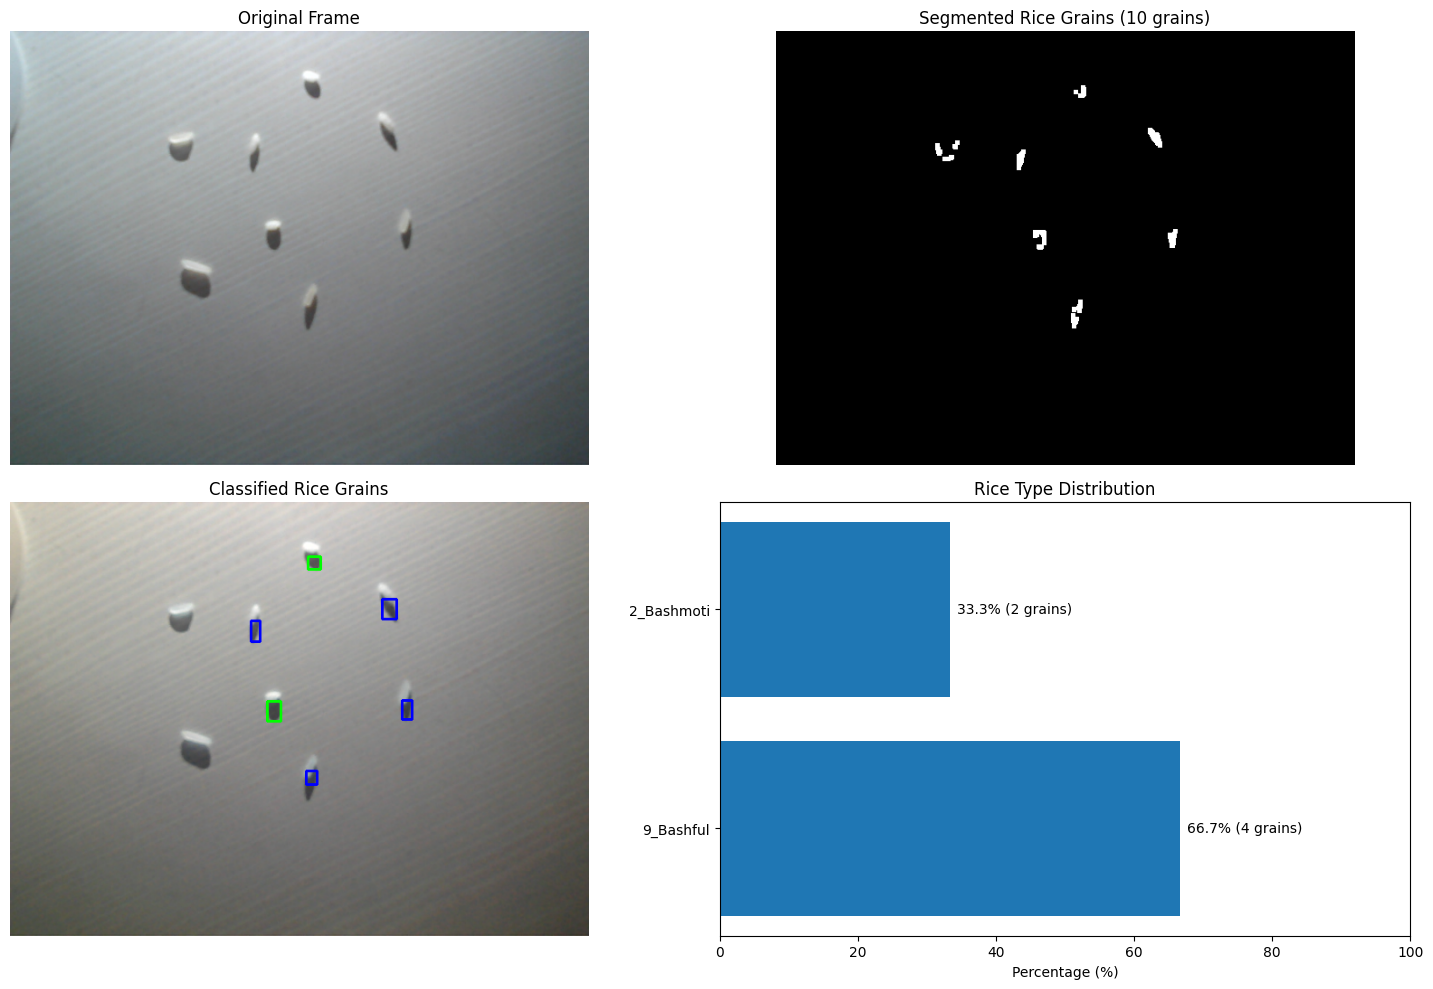


Rice Type Distribution:
9_Bashful: 66.7% (4 grains)
2_Bashmoti: 33.3% (2 grains)

Total rice grains: 6


In [11]:
try:
    model = models.load_model('rice_classifier_model.h5')
    predict_from_camera_with_area_percentage(model)     
except Exception as e:
    print(f"Error: {e}")
    print("Could not load model. Please train the model first.")

Loading dataset...
Loaded 2410 images with 2 classes



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 


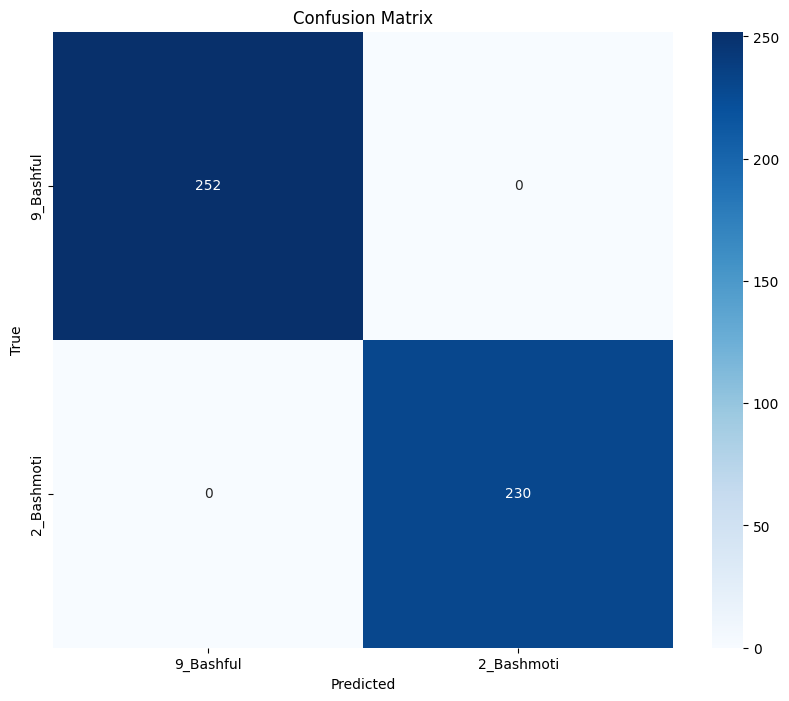


Classification Report:
              precision    recall  f1-score   support

   9_Bashful       1.00      1.00      1.00       252
  2_Bashmoti       1.00      1.00      1.00       230

    accuracy                           1.00       482
   macro avg       1.00      1.00      1.00       482
weighted avg       1.00      1.00      1.00       482



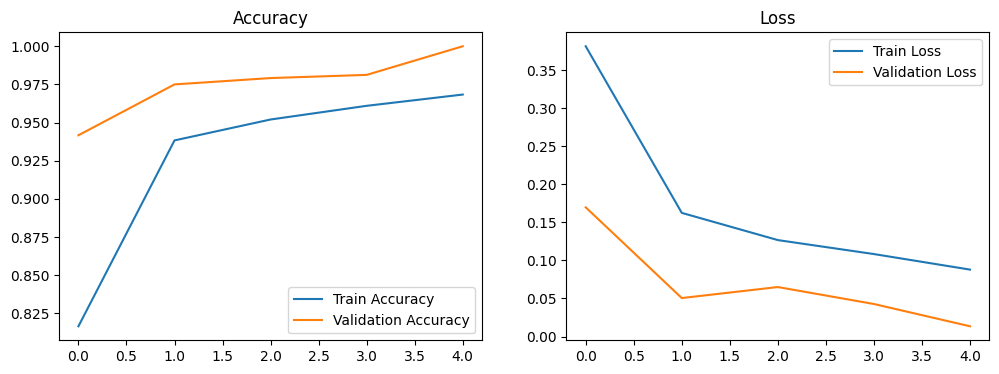

d:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\tf_keras\src\engine\training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as 'rice_classifier_model.h5'


In [10]:
model = train_model()
# Save the trained model
if model:
    model.save('rice_classifier_model.h5')
    print("Model saved as 'rice_classifier_model.h5'")

In [ ]:
params = adjust_segmentation_parameters()
if params:
    print("Saved parameters:", params)
    # Save parameters to a file if needed
    import json
    with open('segmentation_params.json', 'w') as f:
        json.dump(params, f)
    print("Parameters saved to segmentation_params.json")

Adjust the parameters and press 's' to save them, 'q' to quit


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 2 dimension(s)

: 

In [ ]:
def main():
    print("Rice Classification with Camera Input")
    print("1. Train model")
    print("2. Predict rice type percentages from camera (requires trained model)")
    print("3. Exit")
    
    choice = input("\nEnter your choice (1-3): ")
    
    if choice == '1':
        model = train_model()
        # Save the trained model
        if model:
            model.save('rice_classifier_model.h5')
            print("Model saved as 'rice_classifier_model.h5'")
    elif choice == '2':
        # Try to load existing model
        try:
            model = models.load_model('rice_classifier_model.h5')
            predict_from_camera_with_area_percentage(model)
        except Exception as e:
            print(f"Error: {e}")
            print("Could not load model. Please train the model first.")
    elif choice == '3':
        print("Exiting...")
    else:
        print("Invalid choice!")

# Run the main function
if __name__ == '__main__':
    main()